In [1]:
import json
import matplotlib.pyplot as plt
import csv
import pandas as pd
import numpy as np
import time

parent = 'asl-signs/'
with open(parent+'sign_to_prediction_index_map.json', 'r') as f:
    sign_to_prediction_index_map = json.load(f)

# The 'sign_to_prediction_index_map' variable now contains a Python dictionary Dict[str:int]
print(type(sign_to_prediction_index_map))
print(len(sign_to_prediction_index_map))

<class 'dict'>
250


## Data distribution

(94477, 4)
                                            path  participant_id  sequence_id  \
0  train_landmark_files/26734/1000035562.parquet           26734   1000035562   
1  train_landmark_files/28656/1000106739.parquet           28656   1000106739   
2   train_landmark_files/16069/100015657.parquet           16069    100015657   
3  train_landmark_files/25571/1000210073.parquet           25571   1000210073   
4  train_landmark_files/62590/1000240708.parquet           62590   1000240708   

    sign  
0   blow  
1   wait  
2  cloud  
3   bird  
4   owie  


<Axes: >

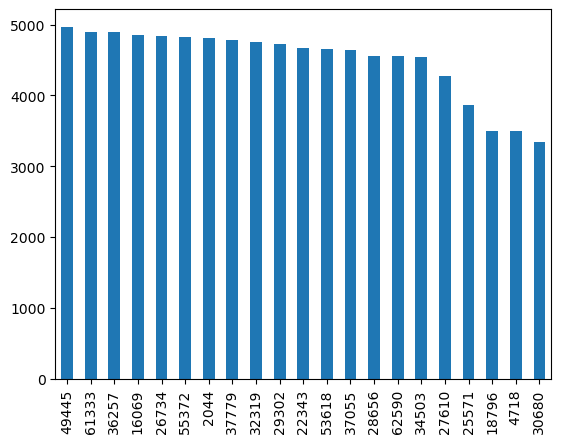

In [2]:
train = pd.read_csv(parent+'train.csv', header=0)
print(train.shape)
print(train.head())
train.participant_id.value_counts().plot(kind='bar')

In [3]:
train.groupby('sign').size().agg(['min','max','mean'])

min     299.000
max     415.000
mean    377.908
dtype: float64

In [4]:
# every sign has at least 299 samples

## Data exploration

In [5]:
import pyarrow.parquet as pq
import pandas as pd

entry = train.iloc[0]
path = entry.path
participant_id = entry.participant_id
sequence_id = entry.sequence_id
sign = entry.sequence_id
df = pd.read_parquet(parent+path)
#    print(df.count())
print(df.columns.tolist())
#    print(df.type.unique())  
for row in range(1000):
    row_values = df.iloc[row]
    print(",".join(str(value) for value in row_values.to_list()))        

['frame', 'row_id', 'type', 'landmark_index', 'x', 'y', 'z']
20,20-face-0,face,0,0.49440014362335205,0.38046982884407043,-0.030626462772488594
20,20-face-1,face,1,0.4960172474384308,0.35073480010032654,-0.05756482854485512
20,20-face-2,face,2,0.5008184909820557,0.3593430519104004,-0.030283458530902863
20,20-face-3,face,3,0.48978811502456665,0.3217797577381134,-0.040622420608997345
20,20-face-4,face,4,0.49530351161956787,0.34182101488113403,-0.06115153431892395
20,20-face-5,face,5,0.49649885296821594,0.3300192654132843,-0.05674387514591217
20,20-face-6,face,6,0.5010387897491455,0.30145734548568726,-0.028559274971485138
20,20-face-7,face,7,0.4361356794834137,0.306363582611084,0.03278343379497528
20,20-face-8,face,8,0.5017918944358826,0.2829946279525757,-0.021999457851052284
20,20-face-9,face,9,0.5010451078414917,0.27174535393714905,-0.02433554083108902
20,20-face-10,face,10,0.5014073252677917,0.22654390335083008,-0.01177428849041462
20,20-face-11,face,11,0.4947373867034912,0.385188609361

#### each face has 468 landmarks;
#### each hand has 21 landmarks;
#### each pose has 33 landmarks.

In [6]:
nlks_face = 468 + 1
nlks_hand = 21 + 1
nlks_pose = 33 + 1

In [7]:
def displayHand(data,text=''):
    plt.figure()
    x_values = [x for x, y in data]
    y_values = [y for x, y in data]
    edges = [(0,1),(1,2),(2,3),(3,4),\
             (0,5),(5,6),(6,7),(7,8),
             (0,17),(17,18),(18,19),(19,20),\
            (9,10),(10,11),(11,12),\
            (13,14),(14,15),(15,16),\
            (5,9),(9,13),(13,17)]
    for ith,jth in edges:
        plt.plot([x_values[ith],x_values[jth]],[y_values[ith],y_values[jth]] ,marker='o')
    plt.text(x_values[0],y_values[0], text, fontsize=12)
    plt.show()  

In [8]:
def display(data):
    plt.figure()
    x_values = [x for x, y in data]
    y_values = [y for x, y in data]
    plt.scatter(x_values,y_values,s=0.5)
    plt.xlim(0,1)
    plt.ylim(0,1)
    plt.show() 

## array dimension for hands: (# of frames, # of landmarks, 2)

In [9]:
isnoface = False
nfrms = 3
ncoord = 2
nfeatures = nfrms * ncoord * ((1-isnoface)*nlks_face + nlks_hand * 2 + nlks_pose)
print(nfeatures)

3282


In [10]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0, 1))
def process_parquet(path):
    arr = np.zeros(0)
    df = pd.read_parquet(path)
    #    print(df.columns.tolist())
    
    frms = df.groupby('frame')
    sign = []
    for idx, frm in frms:
        # create a new dataframe with the group data
        frm_df = pd.DataFrame(frm)
#        print(f'frame : {idx}')
        parts = frm_df.groupby('type')
        for jdx, part in parts:
# for now, we only use hand information
            part_df = pd.DataFrame(part)
            if jdx == 'left_hand':
                lefthand = part_df.loc[:, ['x', 'y']].to_numpy()
                isnanl = np.isnan(lefthand).any()
                lefthand = np.zeros(lefthand.shape) if isnanl else lefthand
            elif jdx == 'right_hand':
                righthand  = part_df.loc[:, ['x', 'y']].to_numpy()
                isnanr = np.isnan(righthand).any()
                righthand = np.zeros(righthand.shape) if isnanr else righthand
                displayHand(righthand,'right hand')
            elif jdx == 'face':
                if not isnoface:
                    face  = part_df.loc[:, ['x', 'y']].to_numpy()
                    isnanf = np.isnan(face).any()
                    face = np.zeros(face.shape) if isnanf else face
            elif jdx == 'pose':
                pose  = part_df.loc[:, ['x', 'y']].to_numpy()
                isnanp = np.isnan(pose).any()
                pose = np.zeros(pose.shape) if isnanp else pose
        
# we create a frame, ignoring pose and face for now
        frame = np.concatenate(([] if isnoface else [scaler.fit_transform(face)]) + 
                               [scaler.fit_transform(lefthand),
                                scaler.fit_transform(righthand),
                                scaler.fit_transform(pose)], axis=0)
        pos = ([] if isnoface else [np.mean(face, axis=0,keepdims=True)]) +  \
            [np.mean(lefthand, axis=0,keepdims=True),
             np.mean(righthand, axis=0,keepdims=True),
             np.mean(pose, axis=0,keepdims=True)]
        frame = np.concatenate([frame]+pos, axis=0)
        isinvalid =  (isnanl and isnanr) or isnanp or (not isnoface and isnanf)
        if not isinvalid:
            sign.append(frame)
    avframe = np.mean(sign, axis=0)
    stdframe = np.std(sign, axis=0)

    arr = np.append(arr,sign[0])
    arr = np.append(arr,avframe)
    arr = np.append(arr,stdframe)
#    print(arr.shape)

    return arr

In [11]:
import multiprocessing

reading 0th data point


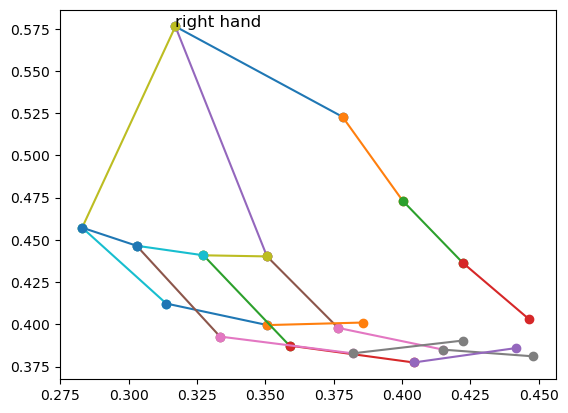

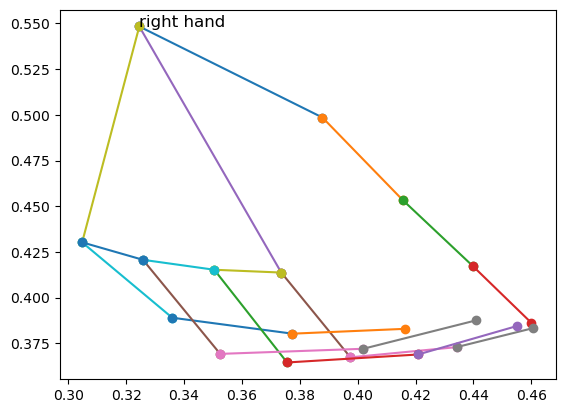

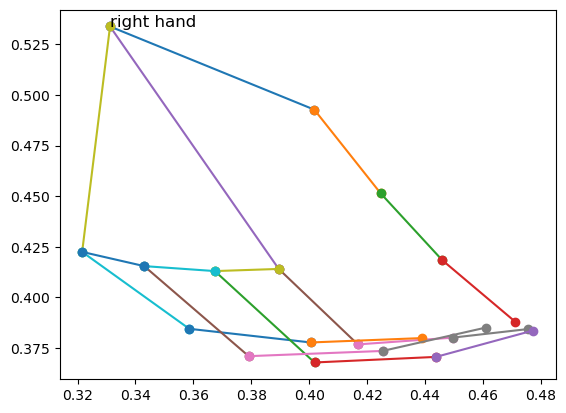

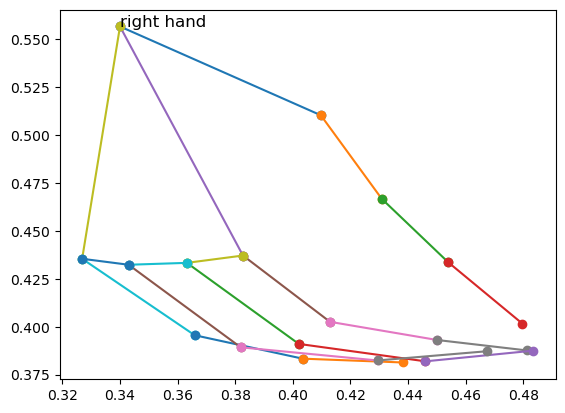

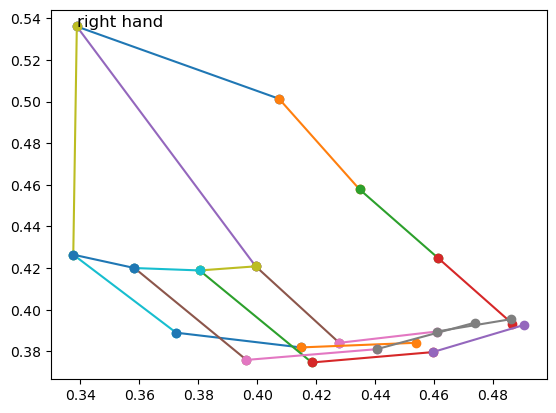

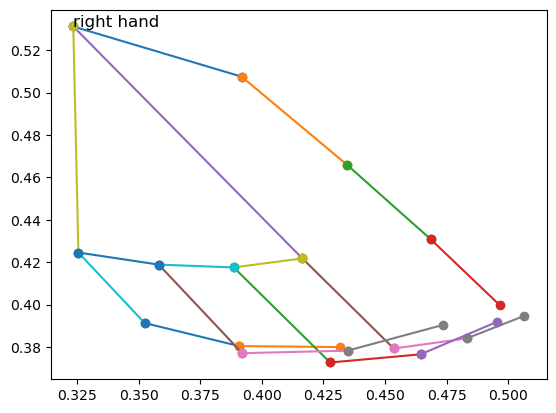

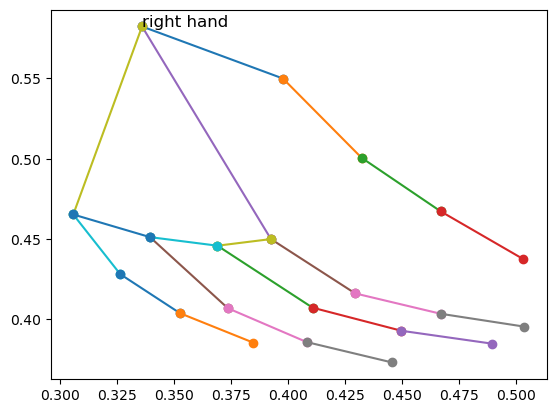

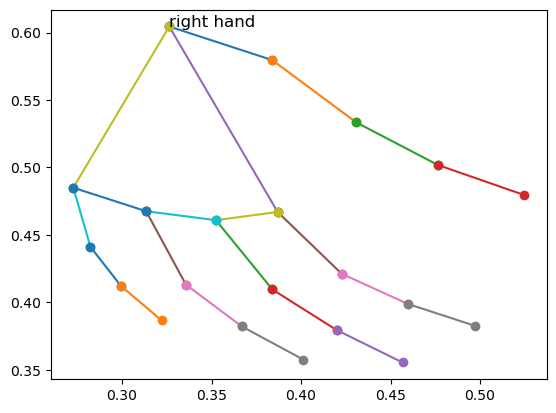

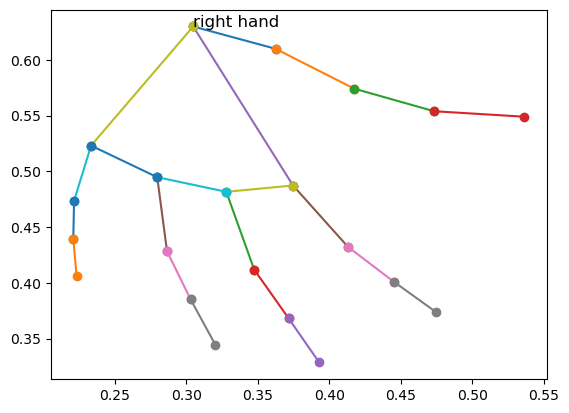

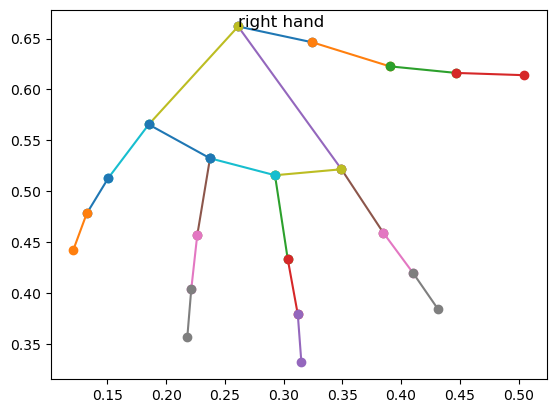

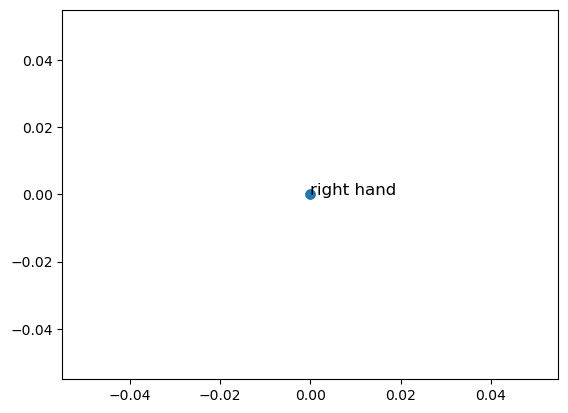

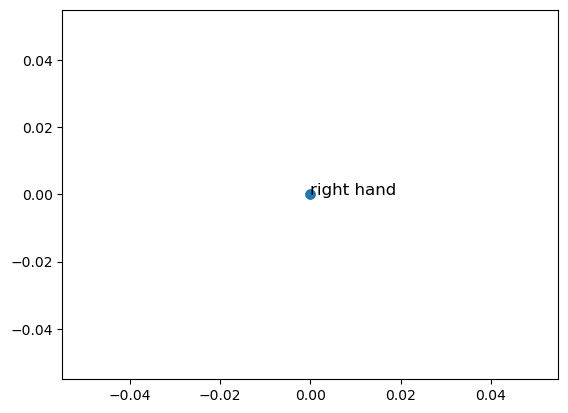

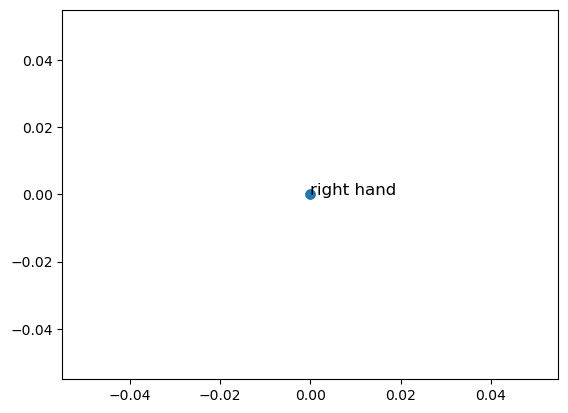

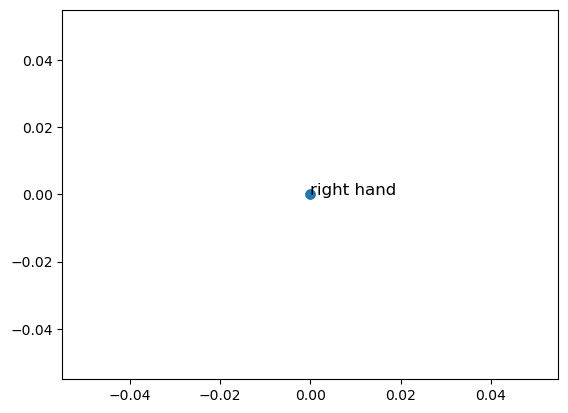

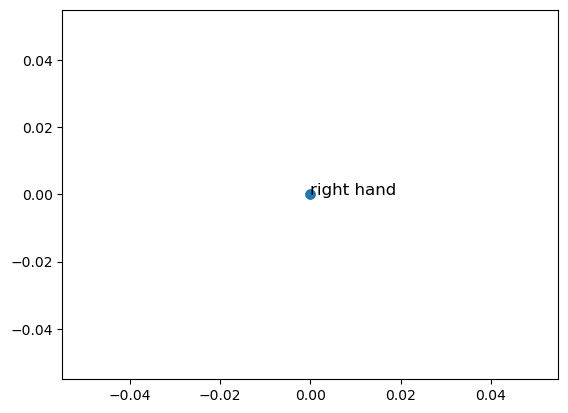

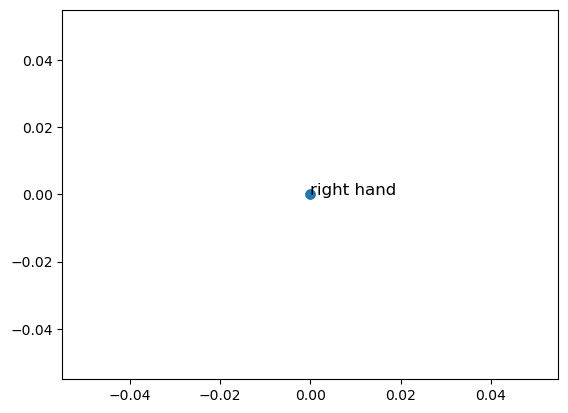

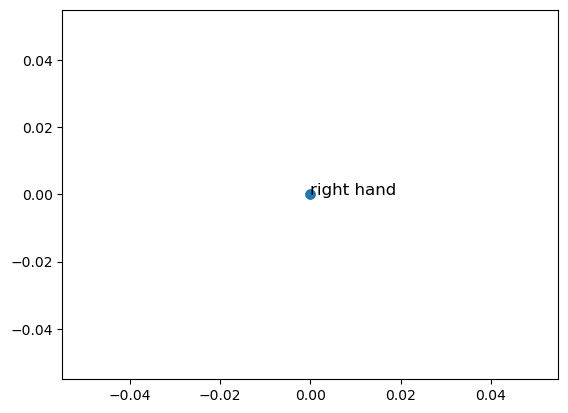

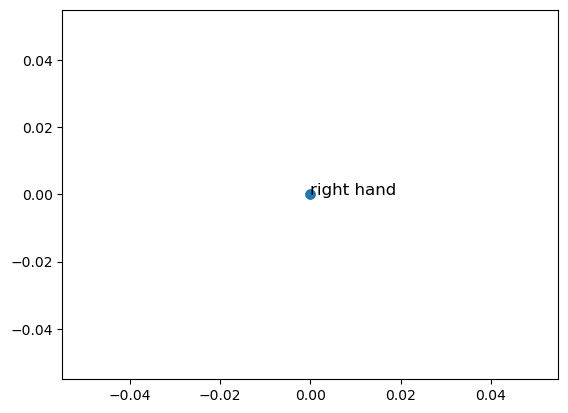

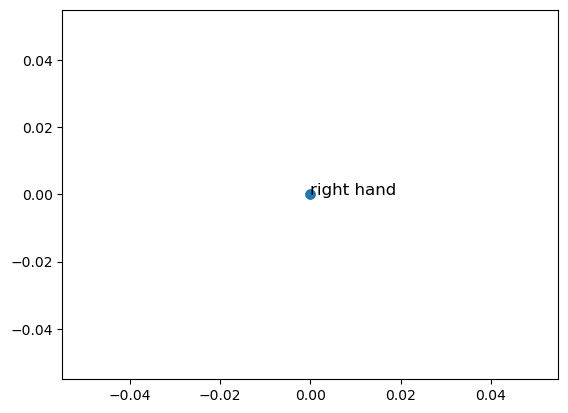

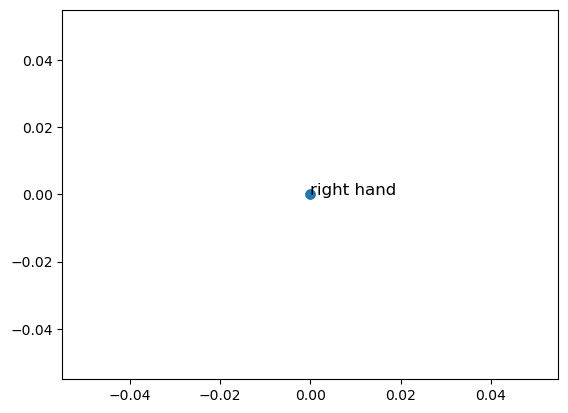

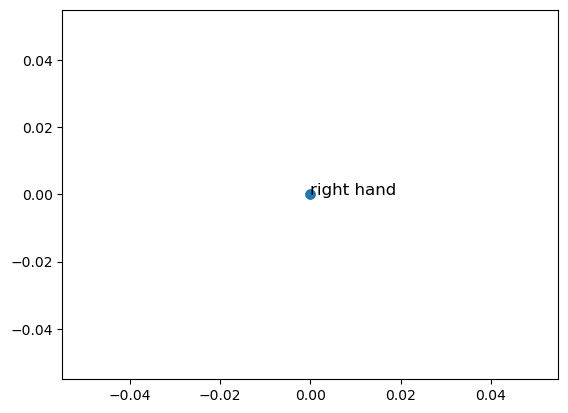

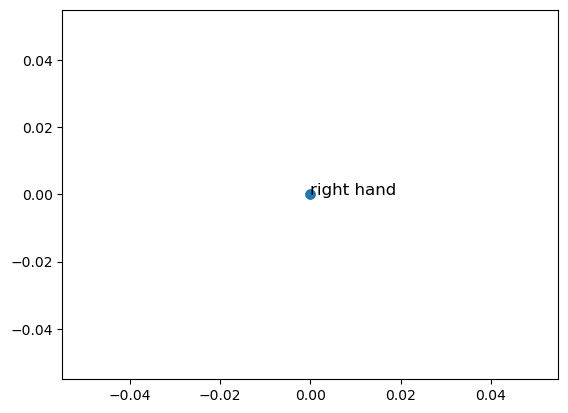

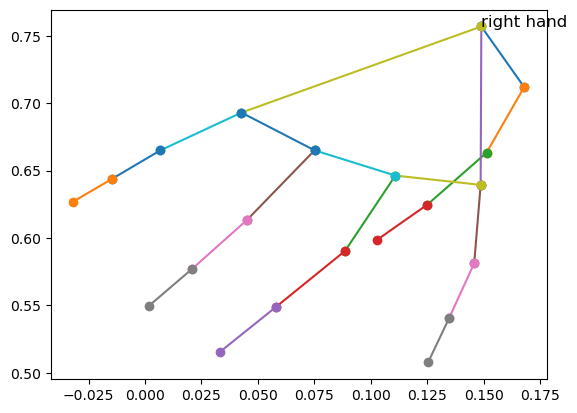

(1, 3282) (3282,)
(1,)
1.547084093093872


In [12]:
input_arr = np.zeros((0,nfeatures))
labels_arr = np.zeros((0,)) 
start_time = time.time()
#for i in range(train.shape[0]):
for i in range(0,1):
    print(f'reading {i}th data point')
    entry = train.iloc[i]
    path = entry.path
    signName = entry.sign
    arr = process_parquet(parent+path)
    input_arr = np.vstack((input_arr, arr))
    labels_arr = np.append(labels_arr, [sign_to_prediction_index_map[signName]])
print(input_arr.shape,arr.shape)
print(labels_arr.shape)
#print(input_arr.shape)  
#print(type(input_arr))
end_time = time.time()
elapsed_time = end_time - start_time
print(elapsed_time)

# save data to .npy file

In [13]:
if input_arr.shape[0] > 10000:
    print(input_arr.shape)
    np.save('inputs.npy', arr=input_arr)
    np.save('labels.npy', arr=labels_arr)
else:
    print(input_arr.shape)
    np.save('inputs_small.npy', arr=input_arr)
    np.save('labels_small.npy', arr=labels_arr)

(1, 3282)


In [14]:
!du -sch inputs.npy labels.npy

108M	inputs.npy
248K	labels.npy
108M	total


In [236]:
read_in = np.load('inputs.npy')
read_la = np.load('labels.npy')

# Print the shape of the array
print(read_in.shape)
print(read_la.shape)

(94477, 450)
(94477,)


In [238]:
!du -sch inputs_small.npy labels_small.npy

4.0K	inputs_small.npy
196K	labels_small.npy
200K	total
